In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-be

100%|██████████| 170498071/170498071 [00:03<00:00, 45656839.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 85.6MB/s]


Epoch [1], Loss: 2.7764, Accuracy: 12.90%
Validation - Clean Loss: 3.7473, Clean Accuracy: 13.65%
Validation - Adversarial Loss: 3.7814, Adversarial Accuracy: 10.75%
Epoch [2], Loss: 2.0931, Accuracy: 22.52%
Validation - Clean Loss: 1.8993, Clean Accuracy: 30.36%
Validation - Adversarial Loss: 2.0450, Adversarial Accuracy: 11.00%
Epoch [3], Loss: 1.8453, Accuracy: 30.54%
Validation - Clean Loss: 1.7692, Clean Accuracy: 33.90%
Validation - Adversarial Loss: 2.1762, Adversarial Accuracy: 5.90%
Epoch [4], Loss: 1.7113, Accuracy: 35.75%
Validation - Clean Loss: 1.5979, Clean Accuracy: 41.19%
Validation - Adversarial Loss: 2.2719, Adversarial Accuracy: 7.17%
Epoch [5], Loss: 1.5652, Accuracy: 41.89%
Validation - Clean Loss: 1.5439, Clean Accuracy: 44.31%
Validation - Adversarial Loss: 2.4375, Adversarial Accuracy: 5.68%


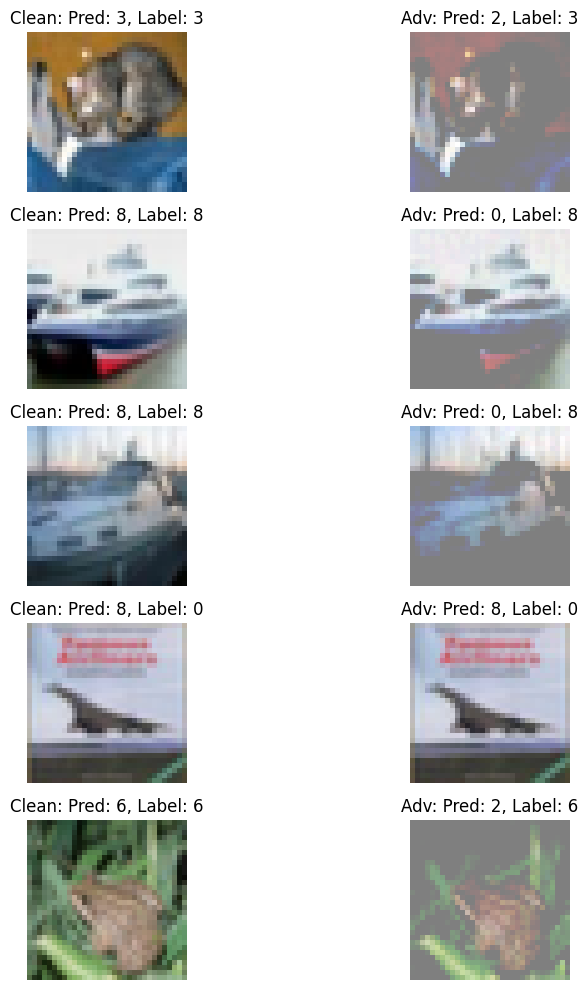

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchattacks
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import wide_resnet50_2

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 data transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

# Load a pretrained WideResNet-28-10 model
model = wide_resnet50_2(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust the final layer for CIFAR-10
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Initialize AutoAttack
autoattack = torchattacks.AutoAttack(model, eps=0.03)

# Training function
def train(model, trainloader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss and accuracy
        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    return epoch_loss, epoch_accuracy

# Evaluation function
def evaluate(model, testloader, criterion, attack=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Apply adversarial attack if specified
            if attack is not None:
                inputs = attack(inputs, labels)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = 100 * correct / total
    return loss, accuracy

# Main training and evaluation loop
num_epochs = 5  # You can increase this to 50+ for full training
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, trainloader, optimizer, criterion, epoch)
    clean_loss, clean_accuracy = evaluate(model, testloader, criterion)
    adv_loss, adv_accuracy = evaluate(model, testloader, criterion, attack=autoattack)
    
    print(f"Validation - Clean Loss: {clean_loss:.4f}, Clean Accuracy: {clean_accuracy:.2f}%")
    print(f"Validation - Adversarial Loss: {adv_loss:.4f}, Adversarial Accuracy: {adv_accuracy:.2f}%")
    
    scheduler.step()

# Visualize some adversarial examples
def visualize_adversarial_examples(model, dataloader, attack, num_examples=5):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Get clean predictions
    outputs = model(images)
    clean_preds = torch.argmax(outputs, 1)

    # Generate adversarial examples
    adv_images = attack(images, labels)
    adv_outputs = model(adv_images)
    adv_preds = torch.argmax(adv_outputs, 1)

    # Plot the clean and adversarial images
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))
    for i in range(num_examples):
        # Display clean image
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5 + 0.5)  # Denormalize
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Clean: Pred: {clean_preds[i].item()}, Label: {labels[i].item()}")
        axes[i, 0].axis('off')

        # Display adversarial image
        adv_img = adv_images[i].cpu().detach().numpy().transpose(1, 2, 0)

        adv_img = (adv_img * 0.5 + 0.5)  # Denormalize
        axes[i, 1].imshow(adv_img)
        axes[i, 1].set_title(f"Adv: Pred: {adv_preds[i].item()}, Label: {labels[i].item()}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize adversarial examples after training
visualize_adversarial_examples(model, testloader, autoattack)
